In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'./datasets/hospital_augment_train_addv3.csv')

In [4]:
df.head()

,gen_data,true_data
0,คลินิกรุงเทพพ์ัทยาสาขาจ๎อมเทียน,คลินิกกรุงเทพพัทยาสาขาจอมเทียน
1,คลินิกกรุงเทพระยองสาขาบ่ะวิน,คลินิกกรุงเทพระยองสาขาบ่อวิน
2,คลินกกรุงเทพระยองสาขาบ้านฉาง,คลินิกกรุงเทพระยองสาขาบ้านฉาง
3,คลินิกกรุงฎเทพระยองสาขาปลวกแดง,คลินิกกรุงเทพระยองสาขาปลวกแดง
4,คลินิกไทยอินเตอร์กาฌรแพทย์ผเ2กาะพงัน),คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)


In [5]:
hospital_gen_train = list(df['gen_data'])
hospital_true_train = list(df['true_data'])

In [6]:
df_test = pd.read_csv(r'./datasets/hospital_augment_test_addv3.csv')

In [7]:
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [8]:
len(hospital_gen_train)

52014

In [9]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent 

In [10]:
from pythainlp import thai_letters

In [11]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [12]:
char_set = label_map_0+label_map_1

In [13]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [14]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [15]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [16]:
input_texts = []
target_texts = []

In [17]:
hospital_gen_train[:10]

['คลินิกรุงเทพพ์ัทยาสาขาจ๎อมเทียน',
 'คลินิกกรุงเทพระยองสาขาบ่ะวิน',
 'คลินกกรุงเทพระยองสาขาบ้านฉาง',
 'คลินิกกรุงฎเทพระยองสาขาปลวกแดง',
 'คลินิกไทยอินเตอร์กาฌรแพทย์ผเ2กาะพงัน)',
 'คลินิกพญาไทเวชกทรรม่อวิน',
 'คลินิกรวมแพทย์นิคม',
 'คลินิกรัสุขภาพจ.ระยอ',
 'คลินิกโรงพยาบาลกรุงเทพพัทยาสาปานาเกลือ',
 'คลินิกโรงพยาบาลกรุงเทพัฉยาสาขาบุญสัมพันธ์']

In [18]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i])
    target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 52014


In [19]:
input_texts[0],target_texts[0]

('คลินิกรุงเทพพ์ัทยาสาขาจ๎อมเทียน', '\tคลินิกกรุงเทพพัทยาสาขาจอมเทียน\n')

In [20]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 78
Max Dec Len: 75


In [21]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [22]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((52014, 78, 93), (52014, 75, 93), (52014, 75, 93))

In [23]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [24]:
len(input_texts),len(target_texts)

(52014, 52014)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [26]:
batch_size = 128
epochs = 100
latent_dim = 256

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [27]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [28]:
num_dec_tokens

93

In [29]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [30]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 716800      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [58]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=50)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_gendata_v5.h5",
            save_best_only=True,
            monitor='accuracy',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [59]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 200,validation_split=0.1,
          batch_size = batch_size,callbacks=[earlystop_callback,saveModel_callback])

31e-04 - accuracy: 0.2886 - val_loss: 0.0058 - val_accuracy: 0.2796
Epoch 45/200
46720/46812 [============================>.] - ETA: 0s - loss: 9.7565e-04 - accuracy: 0.2890
Epoch 00045: accuracy improved from 0.28861 to 0.28896, saving model to models/bilstm_hosipital_gendata_v5.h5
46812/46812 [==============================] - 30s 651us/sample - loss: 9.7454e-04 - accuracy: 0.2890 - val_loss: 0.0043 - val_accuracy: 0.2792
Epoch 46/200
46720/46812 [============================>.] - ETA: 0s - loss: 5.0579e-04 - accuracy: 0.2892
Epoch 00046: accuracy improved from 0.28896 to 0.28915, saving model to models/bilstm_hosipital_gendata_v5.h5
46812/46812 [==============================] - 30s 648us/sample - loss: 5.0773e-04 - accuracy: 0.2892 - val_loss: 0.0044 - val_accuracy: 0.2786
Epoch 47/200
46720/46812 [============================>.] - ETA: 0s - loss: 4.8007e-04 - accuracy: 0.2891
Epoch 00047: accuracy did not improve from 0.28915
46812/46812 [==============================] - 31s 657u

In [60]:
import matplotlib.pyplot as plt

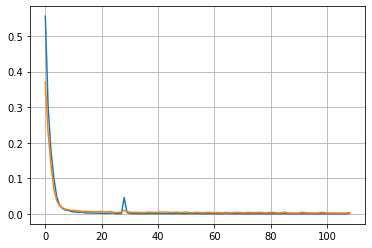

In [61]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()

In [62]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v5.h5')
decoder_model.save('decoder_v5.h5')

In [31]:
from tensorflow.keras.models import load_model

In [32]:
encoder_model = load_model('encoder_v5.h5',compile=False)

In [33]:
decoder_model = load_model('decoder_v5.h5',compile=False)

In [70]:
b = input_texts[1275]

In [71]:
len(b) + b.count(' ')

72

In [34]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [64]:
pred_sent_train = []
for seq_index in range(num_samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_train.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

-
Wrong sentence: โรงพยาบาลรันบุรี
Corrected sentence: โรงพยาบาลรัตนบุรี

Ground Truth: 	โรงพยาบาลรัตนบุรี

-
Wrong sentence: โรงพยาบาฬรัตนวาปี
Corrected sentence: โรงพยาบาลรัตนวาปี

Ground Truth: 	โรงพยาบาลรัตนวาปี

-
Wrong sentence: โรงพไาบธาลรัตภูมิ
Corrected sentence: โรงพยาบาลรัตภูมิ

Ground Truth: 	โรงพยาบาลรัตภูมิ

-
Wrong sentence: โรงพยาโบาลรัทรินทผ์
Corrected sentence: โรงพยาบาลรัทรินทร์

Ground Truth: 	โรงพยาบาลรัทรินทร์

-
Wrong sentence: โรงพย5าบาลรัษฎา
Corrected sentence: โรงพยาบาลรัษฎา

Ground Truth: 	โรงพยาบาลรัษฎา

-
Wrong sentence: โรงพ3ยาบาลราชดาเนินตัง
Corrected sentence: โรงพยาบาลราชดาเนินตรัง

Ground Truth: 	โรงพยาบาลราชดาเนินตรัง

-
Wrong sentence: โรงพยาบาลภราชธานี
Corrected sentence: โรงพยาบาลราชธานี

Ground Truth: 	โรงพยาบาลราชธานี

-
Wrong sentence: โรงพยาบาลราชธานีโรจนะ
Corrected sentence: โรงพยาบาลราชธานีโรจนะ

Ground Truth: 	โรงพยาบาลราชธานีโรจนะ

-
Wrong sentence: โรๅงพยาบลราชบุรี
Corrected sentence: โรงพยาบาลราชบุรี

Ground Truth: 	โรงพยาบาลราชบุรี

-
Wr

In [45]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i])
    test_y.append(output_text)
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 2606


In [46]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 74
Max Dec Len: 75


In [47]:
##### Validation Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [48]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [71]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

2606/2606 [==============================] - 4s 1ms/sample - loss: 0.0033 - accuracy: 0.2959


[0.003306075667365435, 0.29592222]

In [50]:
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    sent = str(''.join(lst))
    sent_2 = sent.strip('\n')
    print(seq_index)
   
    #print('-')
    #print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', sent_2)
    #print('Ground Truth:',target_texts[seq_index])


 โรงพยาบาลพรหมบุรี
2185
Corrected sentence: โรงพยาบาลพรหมพิราม
2186
Corrected sentence: โรงพยาบาลพร้อมแพทย์
2187
Corrected sentence: โรงพยาบาลพระจอมเกล้า
2188
Corrected sentence: โรงพยาบาลพระทองคำ เฉลิมพระเกียรติ 80 พรรษา
2189
Corrected sentence: โรงพยาบาลพระนครศรีอยุธยา
2190
Corrected sentence: โรงพยาบาลพระนั่งเกล้า
2191
Corrected sentence: โรงพยาบาลพระนารายณ์มหาราช
2192
Corrected sentence: โรงพยาบาลพระปกเกล้า
2193
Corrected sentence: โรงพยาบาลพระยืน
2194
Corrected sentence: โรงพยาบาลพระรามเกา้
2195
Corrected sentence: โรงพยาบาลพระศรีมหาโพธิ์
2196
Corrected sentence: โรงพยาบาลพระสมุทรเจดีย์
2197
Corrected sentence: โรงพยาบาลพระอาจารย์แบน ธนากโร
2198
Corrected sentence: โรงพยาบาลพระอาจารย์ฝั้นอาจาโร
2199
Corrected sentence: โรงพยาบาลพรานกระต่าย
2200
Corrected sentence: โรงพยาบาลพลับพลาชัย
2201
Corrected sentence: โรงพยาบาลพหลพลพยุหเสนา
2202
Corrected sentence: โรงพยาบาลพ่อท่านคล้ายวาจาสิทธิ์
2203
Corrected sentence: โรงพยาบาลพะเยา
2204
Corrected sentence: โรงพยาบาลพะเยาราม
2205
Correct

In [51]:
test_y[0]

'\tโรงพยาบาลสนม\n'

In [52]:
pred_test = []
for i,key in enumerate(pred_sent_test):
    b = key[:-1]
    sent = ''.join(b)
    pred_test.append(sent)
    print('Input:', test_x[i])
    print('Prediction:', sent)
    print('Ground truth:', test_y[i])

าลสมเด็จพระปิยะมหารชรมณียเขต
Prediction: โรงพยาบาลสมเด็จพระปิยะมหาราชรมณียเขต
Ground truth: 	โรงพยาบาลสมเด็จพระปิยะมหาราชรมณียเขต

Input: โรงพยาบาล์สมเด็"จพระพุทธเลิศหล้า
Prediction: โรงพยาบาลสมเด็จพระพุทธเลิศหล้า
Ground truth: 	โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

Input: โรงพยาบาลสมเด็จพระพุษธเลิศหล้า
Prediction: โรงพยาบาลสมเด็จพระพุทธเลิศหล้า
Ground truth: 	โรงพยาบาลสมเด็จพระพุทธเลิศหล้า

Input: โรงพยาบาลสมเด็จพระยุอพราชกระนวน
Prediction: โรงพยาบาลสมเด็จพระยุพราชกระนวน
Ground truth: 	โรงพยาบาลสมเด็จพระยุพราชกระนวน

Input: โรงพยาบาลสมเด็หจพระยุพรผาชกุฉินารายณ์
Prediction: โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์
Ground truth: 	โรงพยาบาลสมเด็จพระยุพราชกุฉินารายณ์

Input: โรงพยาบ7าลสมเด็จพระยุพฝาชฉวาง
Prediction: โรงพยาบาลสมเด็จพระยุพราชฉวาง
Ground truth: 	โรงพยาบาลสมเด็จพระยุพราชฉวาง

Input: โรงพราบาลสมเด็จพระยุพราชเชียงขง
Prediction: โรงพยาบาลสมเด็จพระยุพราชเชียงของ
Ground truth: 	โรงพยาบาลสมเด็จพระยุพราชเชียงของ

Input: โรงพยาบษาลสม็จพญะยุพราชด่านซ้าย
Prediction: โรงพยาบาลสมเด็จพระยุพราชด่านซ้

In [53]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(test_y):
    test = key[1:-1] 
    if test == pred_test[i]:
        count += 1
    else:
        wrong_pred.append(pred_test[i])
        wrong_true.append(test)
        wrong_input.append(test_x[i])

In [54]:
count

2473

In [55]:
len(test_y)

2606

In [56]:
count - len(test_y)

-133

In [57]:
count/len(test_y)

0.9489639293937069

In [58]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Gound Thrust:', wrong_true[i])
    print('-')

Input: โรงพยาบาลถมเด็จ
Prediction: โรงพยาบาลเจ็ด
Gound Thrust: โรงพยาบาลสมเด็จ
-
Input: โรงพยาบาลสศนติสุข
Prediction: โรงพยาบาลสุขิวัน
Gound Thrust: โรงพยาบาลสันติสุข
-
Input: โรงพยาบาะลสคำโรงทาบ
Prediction: โรงพยาบาลสังระพระ
Gound Thrust: โรงพยาบาลสำโรงทาบ
-
Input: โรงพยา)าลมนองม่วง
Prediction: โรงพยาบาลแม่วงงอว
Gound Thrust: โรงพยาบาลหนองม่วง
-
Input: โรงพยาบัาลหนองหิณน
Prediction: โรงพยาบาลหนองหินม
Gound Thrust: โรงพยาบาลหนองหิน
-
Input: โรงพยาบาลหลวงพ่ตเ์ิ่น
Prediction: โรงพยาบาลหลวงพระเมิม
Gound Thrust: โรงพยาบาลหลวงพ่อเปิ่น
-
Input: โรงพยาบาลอุทัยธานแ
Prediction: โรงพยาบาลอุทัย
Gound Thrust: โรงพยาบาลอุทัยธานี
-
Input: คลิํกโรงพยาบาลสมิติเวชศรีราชา(อีสเทร์ึซีบอรด)
Prediction: คลินิกโรงพยาบาลสมิติเวชศรีราชา
Gound Thrust: คลินิกโรงพยาบาลสมิติเวชศรีราชา(อีสเทิร์นซีบอร์ด)
-
Input: โรงพยาบาลกระฎุรี
Prediction: โรงพยาบาลกระปุน
Gound Thrust: โรงพยาบาลกระบุรี
-
Input: โรงพยาบลกคปงชัยพัฒน์
Prediction: โรงพยาบาลกะปัชพันธิ
Gound Thrust: โรงพยาบาลกะปงชัยพัฒน์
-
Input: โรงพยาบาลกุณภวาปี
Predi

In [88]:
wrong_pred[3],wrong_input[3],wrong_true[3]

('โรงพยาบาลแม่วงงอว', 'โรงพยา)าลมนองม่วง', 'โรงพยาบาลหนองม่วง')

In [59]:
df_wrong_input = pd.DataFrame(wrong_input)
df_wrong_true = pd.DataFrame(wrong_true)

In [60]:
df_wrong_input.columns=['gen_data']
df_wrong_true.columns=['true_data']

In [61]:
df_col_merged =pd.concat([df_wrong_input,df_wrong_true],axis=1)

In [62]:
df_col_merged.to_csv('hospital_wrong5.csv',index=False)

In [89]:
from char_error_rate import get_char_error_rate

In [90]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [91]:
pred_test_output = []
for txt in pred_test:
    pred_test_output.append(createSpace_for_cer(txt))

In [92]:
ground_test =[]
for txt in test_y:
    ground_test.append(createSpace_for_cer(txt))

In [93]:
input_test = []
for txt in test_x:
    input_test.append(createSpace_for_cer(txt))

In [94]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],pred_test_output[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:10.420570663218545%


In [95]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],input_test[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

Character Error Rate for Test Set:16.272929164805888%


In [81]:
test_x[50],test_y[50]

('โรงพยาบาพรหมบุรี', '\tโรงพยาบาลพรหมบุรี\n')

In [112]:
pred_sent_test[50]

['โ',
 'ร',
 'ง',
 'พ',
 'ย',
 'า',
 'บ',
 'า',
 'ล',
 'พ',
 'ร',
 'ห',
 'ม',
 'บ',
 'ุ',
 'ร',
 'ี',
 '\n']

In [210]:
text50 = ''.join(pred_sent_test[50])
text50

'โรงพยาบาลพรหมบุรี\n'

In [108]:
input_seq = encoder_input_data_test[50:51]

In [87]:
input_seq.shape

(1, 52, 93)

In [101]:
input_seq[0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [109]:
states_value = encoder_model.predict(input_seq)

In [202]:
states_value[0].shape

(1, 256)

In [203]:
states_value[1].shape

(1, 256)

In [110]:
target_seq = np.zeros((1, 1, num_dec_tokens))

In [95]:
target_seq.shape

(1, 1, 93)

In [96]:
target_seq[0, 0, char2int['\t']] = 1

In [97]:
target_seq

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

In [105]:
out = [target_seq]+states_value
len(out)

3

In [205]:
output_tokens,h,c = decoder_model.predict([target_seq] + states_value)

In [ ]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])

In [208]:
np.argmax(output_tokens[0,-1,:])

91

In [111]:
stop_condition = False
decoded_sentence = ''
decoded_list =[]
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = int2char[sampled_token_index]
    decoded_sentence += sampled_char
    
    decoded_list.append(sampled_char)
    print('Decoder seq:{}'.format(''.join(decoded_list)))
    print('Character:{}'.format(sampled_char))

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

        # Update states
    states_value = [h, c]

Decoder seq:โ
Character:โ
Decoder seq:โร
Character:ร
Decoder seq:โรง
Character:ง
Decoder seq:โรงพ
Character:พ
Decoder seq:โรงพย
Character:ย
Decoder seq:โรงพยา
Character:า
Decoder seq:โรงพยาบ
Character:บ
Decoder seq:โรงพยาบา
Character:า
Decoder seq:โรงพยาบาล
Character:ล
Decoder seq:โรงพยาบาลพ
Character:พ
Decoder seq:โรงพยาบาลพร
Character:ร
Decoder seq:โรงพยาบาลพรห
Character:ห
Decoder seq:โรงพยาบาลพรหม
Character:ม
Decoder seq:โรงพยาบาลพรหมบ
Character:บ
Decoder seq:โรงพยาบาลพรหมบุ
Character:ุ
Decoder seq:โรงพยาบาลพรหมบุร
Character:ร
Decoder seq:โรงพยาบาลพรหมบุรี
Character:ี
Decoder seq:โรงพยาบาลพรหมบุรี

Character:

